# Installing libraries 
* NLTK==3.4  
* yellowbrick 
* Gensim=3.6.0

In [1]:
!pip install nltk==3.4
!pip install yellowbrick -U
!pip install gensim==3.6.0

done
  Created wheel for gensim: filename=gensim-3.6.0-cp37-cp37m-linux_x86_64.whl size=24238200 sha256=080e07af750d34928b59d00afb07e35a75b33aff94ed5407ff5bd1b55c2ca850
  Stored in directory: /root/.cache/pip/wheels/53/c8/f9/afb722099bdb5d73e5807019ce1512fd065502ccc15ea2b5bd
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scattertext 0.1.4 requires gensim>=4.0.0, but you have gensim 3.6.0 which is incompatible.


# Loading Libraries

In [2]:
import base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotly imports
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

# Other imports
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import json

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from wordcloud import WordCloud, STOPWORDS



import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200) # to show more rows.

%matplotlib inline
%load_ext autoreload
%autoreload 2

References :
1. https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
2. https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
3. https://github.com/ElizaLo/NLP-Natural-Language-Processing

In [3]:
df = pd.read_json('../input/careerdb/database.json')

In [4]:
df.rename(columns={'pregrado':'undergraduate',
                   'Universidad':'university',
                   'detalles':'details',
                   'Descripcion':'description',
                  'Registro calificado':'Qualified record',
                  'Nivel de formación':'Level of Education',
                  'Tipo de formación':'Type of training',
                  'Título otorgado':'Title awarded',
                  'Modalidad':'Modality',
                  'Duración':'Duration',
                  'Créditos':'Credits',
                  'Ciudad':'Town'},inplace=True)
df.head()

,undergraduate,university,details,description,SNIES,Qualified record,Level of Education,Type of training,Title awarded,Modality,Duration,Credits,Town
0,especializacion en gerencia de servicios de salud,universidad cooperativa de colombia - sede apa...,campos de accion,el programa de especializacion de gerencia de ...,6742,"registro 20185 del 11 de diciembre de 2015, vi...",posgrado,especializacion,especialista en gerencia de servicio de salud,presencial,2 semestres,30,apartado
1,contaduria publica,universidad cooperativa de colombia - sede apa...,objeto de estudio,las particularidades de este programa que se r...,104897,"resolucion 14090 del 07 de septiembre de 2015,...",pregrado,universitaria,contador publico,presencial,8 semestres,144,apartado
2,derecho,universidad cooperativa de colombia - sede apa...,,"el programa de derecho, estudia el sistema jur...",102434,"resolucion 9967 del 17 de junio de 2020, vigen...",pregrado,universitaria,abogado,presencial,10 semestres,158,apartado
3,psicologia,universidad cooperativa de colombia - sede arauca,,"en la universidad cooperativa de colombia, el ...",54920,"resolucion 16951 del 22 de agosto de 2016​, vi...",pregrado,profesional universitaria,psicologo,presencial,8 semestres,147,arauca
4,derecho,universidad cooperativa de colombia - sede arauca,abordar el sistema juridico como conjunto de n...,el programa de derecho que se ofrece en la ins...,8630,"resolucion 10893 del 01 de junio de 2016, vige...",pregrado,universitaria,abogado,presencial,10 semestres,158,arauca


In [5]:
def nan_check(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    return missing_data

nan_check(df)

,Total,%
Credits,578,19.7
Modality,300,10.2
Title awarded,163,5.5
Duration,77,2.6
Qualified record,68,2.3
Type of training,57,1.9
SNIES,50,1.7
Level of Education,49,1.7
undergraduate,0,0.0
university,0,0.0


In [6]:
df.undergraduate.value_counts()

administracion de empresas                                                     67
contaduria publica                                                             54
derecho                                                                        50
psicologia                                                                     49
ingenieria industrial                                                          40
                                                                               ..
especializacion en organizaciones, responsabilidad social y desarrollo          1
maestria en gerencia de la innovacion empresarial                               1
doctorado en logistica y gestion de cadenas de suministros                      1
especializacion en gerencia estrategica de marca                                1
especializacion en ordenamiento y gestion integral de cuencas hidrograficas     1
Name: undergraduate, Length: 1664, dtype: int64

In [7]:
# Delete words like Master, Doctorat , Especialisation, & Technology.
df1 = df[(df['undergraduate'].str.find('especializacion')==-1) &
    (df['undergraduate'].str.find('maestria')==-1) & 
    (df['undergraduate'].str.find('doctorado')==-1) & 
    (df['undergraduate'].str.find('tecnologia')==-1)]

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1127 entries, 1 to 2936
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   undergraduate       1127 non-null   object
 1   university          1127 non-null   object
 2   details             1127 non-null   object
 3   description         1127 non-null   object
 4   SNIES               1092 non-null   object
 5   Qualified record    1072 non-null   object
 6   Level of Education  1088 non-null   object
 7   Type of training    1080 non-null   object
 8   Title awarded       1028 non-null   object
 9   Modality            1015 non-null   object
 10  Duration            1083 non-null   object
 11  Credits             904 non-null    object
 12  Town                1127 non-null   object
dtypes: object(13)
memory usage: 123.3+ KB


In [8]:
df1.undergraduate.value_counts()

administracion de empresas                            67
contaduria publica                                    54
derecho                                               50
psicologia                                            49
ingenieria industrial                                 40
                                                      ..
licenciatura en educacion para la primera infancia     1
psicologia - medellin                                  1
diseño industrial - bogota                             1
profesional en ciencias ambientales                    1
regencia de farmacia                                   1
Name: undergraduate, Length: 375, dtype: int64

In [9]:
def replace_str(x):
    if (str(x).find('administracion') != -1) or (str(x).find('contaduria') != -1) \
    or (str(x).find('economia') != -1) or (str(x).find('negocios') != -1) \
    or (str(x).find('mercadeo') != -1) or (str(x).find('finanzas') != -1) \
    or (str(x).find('publicidad') != -1) or (str(x).find('comercio') != -1):
        return 'BUSINESS'
    elif str(x).find('ingenieria') != -1:
        return 'ENGINEERING'
    elif (str(x).find('derecho') != -1)   or (str(x).find('psico') != -1) \
    or (str(x).find('comunicacion') != -1) or (str(x).find('social') != -1) \
    or (str(x).find('pedagogia') != -1) or (str(x).find('filosofia') != -1) \
    or (str(x).find('educacion infantil') != -1) or (str(x).find('teologia') != -1) \
    or (str(x).find('antropologia') != -1) or (str(x).find('ciencia politica') != -1) \
    or (str(x).find('historia') != -1) or (str(x).find('sociologia') != -1) \
    or (str(x).find('literatura') != -1) or (str(x).find('ciencias politicas') != -1) \
    or (str(x).find('relaciones internacionales') != -1):
        return 'HUMANITIES AND SOCIAL SCIENCE'
    elif (str(x).find('medicina') != -1) or (str(x).find('enfermeria') != -1) \
    or (str(x).find('odontologia') != -1) or (str(x).find('salud en el trabajo') != -1) \
    or (str(x).find('quirurgica') != -1) :
        return 'HEALTH & MEDICINE'
    elif (str(x).find('nutricion') != -1) :
        return 'NUTRITION AND DIETETICS'
    #elif (str(x).find('nutricion') != -1) :
    #    return 'NUTRITION AND DIETETICS'
    elif (str(x).find('educacion fisica') != -1) or (str(x).find('fisioterapia') != -1):
        return 'SPORTS AND PHYSICAL TRAIN'
    elif (str(x).find('artes plasticas') != -1) or (str(x).find('artes visuales') != -1) \
    or (str(x).find('artes audiovisuales') != -1) or (str(x).find('audiovisuales') != -1) \
    or (str(x).find('produccion cultural') != -1) :
        return 'PLASTIC ARTS, VISUAL ARTS'
    elif (str(x).find('arquitectura') != -1) or (str(x).find('music') != -1) \
    or (str(x).find('diseño') != -1) or (str(x).find('artes') != -1) \
    or (str(x).find('fotografia') != -1):
        return 'ARTS AND DESIGN'
    elif (str(x).find('matematicas') != -1) or (str(x).find('fisica') != -1) \
    or (str(x).find('estadistica') != -1) or (str(x).find('biologia') != -1) \
    or (str(x).find('quimica') != -1) :
        return 'MATH AND PHYSICAL SCIENCES'
    elif (str(x).find('ciencias naturales') != -1) or (str(x).find('biologia') != -1) \
    or (str(x).find('conservacion') != -1) or (str(x).find('medio ambiente') != -1):
        return 'BIOLOGICAL SCIENCE'
    else:
        return 'OTHER'

In [10]:
df1['final_cat'] = df1['undergraduate'].apply(replace_str)
df1['final_cat'].value_counts(normalize = True)

BUSINESS                         0.251996
HUMANITIES AND SOCIAL SCIENCE    0.240461
ENGINEERING                      0.228926
OTHER                            0.100266
HEALTH & MEDICINE                0.062999
ARTS AND DESIGN                  0.048802
MATH AND PHYSICAL SCIENCES       0.041704
SPORTS AND PHYSICAL TRAIN        0.010648
PLASTIC ARTS, VISUAL ARTS        0.007098
BIOLOGICAL SCIENCE               0.005324
NUTRITION AND DIETETICS          0.001775
Name: final_cat, dtype: float64

In [11]:
# Droping OTHER Undergraduate
df1 = df1[df1['final_cat'] != 'OTHER']
# Dropping void Description
df1= df1[df1['description']!='']
# replacing big space
df1['description'] = df1['description'].str.strip('').replace('  ', ' ')

In [18]:
df1.head(2)

,undergraduate,university,details,description,SNIES,Qualified record,Level of Education,Type of training,Title awarded,Modality,Duration,Credits,Town,final_cat
1,contaduria publica,universidad cooperativa de colombia - sede apa...,objeto de estudio,las particularidades de este programa que se r...,104897,"resolucion 14090 del 07 de septiembre de 2015,...",pregrado,universitaria,contador publico,presencial,8 semestres,144,apartado,BUSINESS
2,derecho,universidad cooperativa de colombia - sede apa...,,"el programa de derecho, estudia el sistema jur...",102434,"resolucion 9967 del 17 de junio de 2020, vigen...",pregrado,universitaria,abogado,presencial,10 semestres,158,apartado,HUMANITIES AND SOCIAL SCIENCE


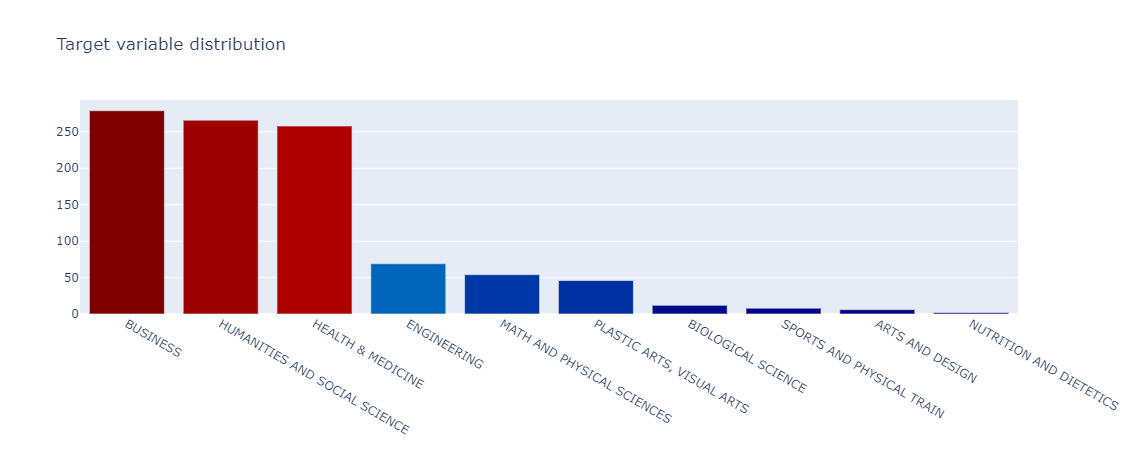

In [19]:
data = [go.Bar(
            x = df1.final_cat.unique(),
            y = df1.final_cat.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = df1.final_cat.value_counts().values
                        ),
            text='Text entries attributed to Final Category'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

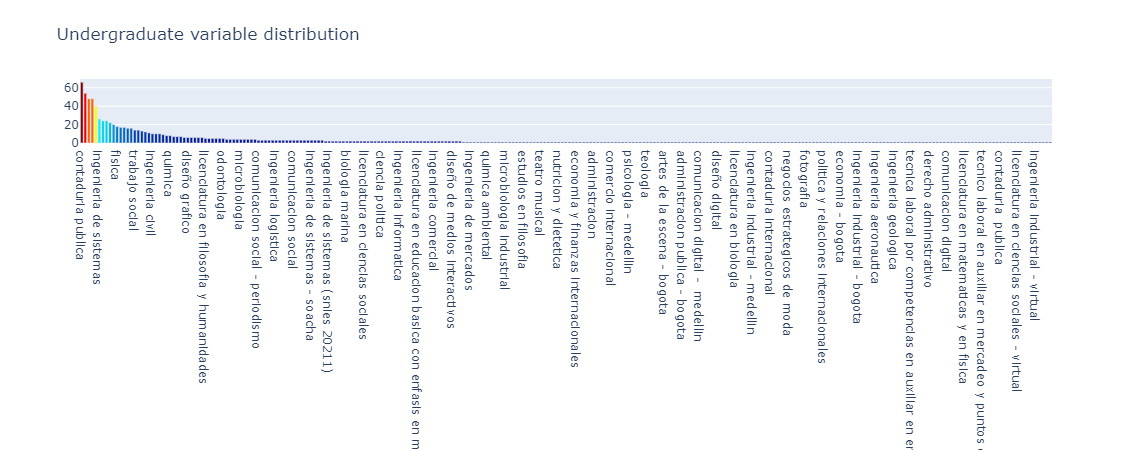

In [20]:
data = [go.Bar(
            x = df1.undergraduate.unique(),
            y = df1.undergraduate.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = df1.undergraduate.value_counts().values
                        ),
            text='Text entries attributed to undergraduate Category'
    )]

layout = go.Layout(
    title='Undergraduate variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

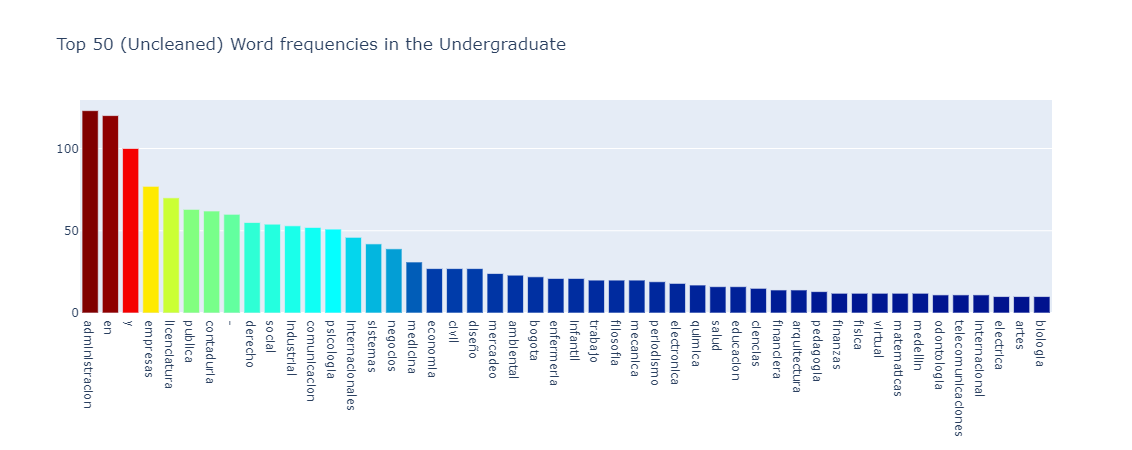

In [21]:
all_words = df1['undergraduate'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the Undergraduate'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

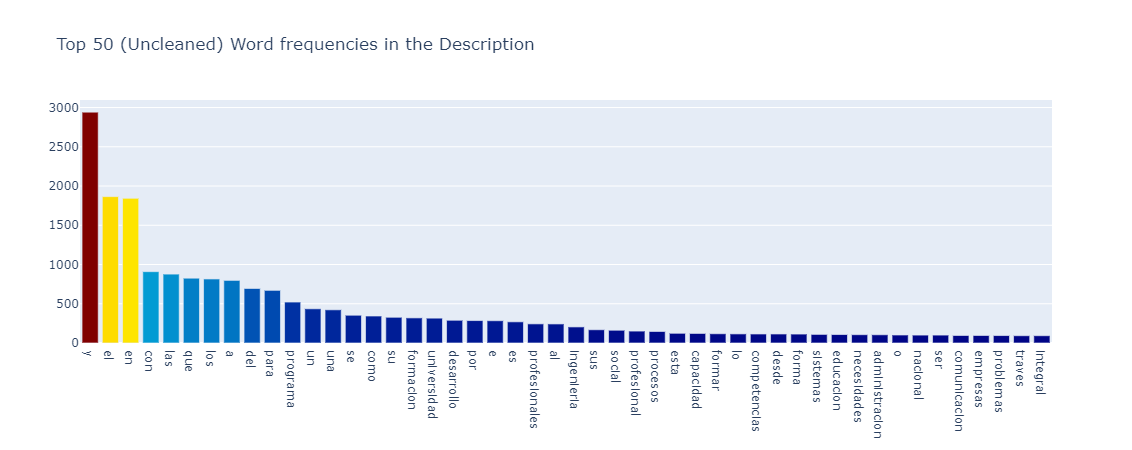

In [22]:
all_words = df1['description'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the Description'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

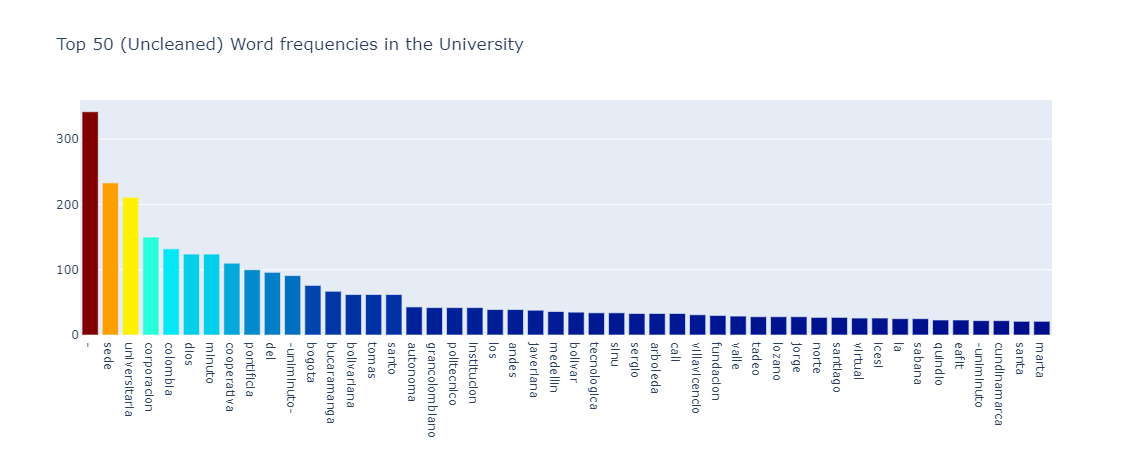

In [23]:
all_words = df1['university'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the University'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

**list of stopwords to add to the spanish stopwords**

In [24]:
stopwords_new = ['universidad','programa',
                 'formacion','desarrollo','profesionales',
                 'colombia', 'estudiante', 'quindio', 'cooperativa', 'santo', 'tomas',
                 'sergio','arboleda','pontificia','bolivariana','acreditacion','resolucion', 
                 'años','ministerio','alta','calidad','nacional','educacion','vigencia','acreditado',
                'más', 'mas', 'unir', 'paises', 'pais', 'espa', 'no', 'os', 'a','d',  'et',  'dame',  'il',]

# NLTK 

* Tokenization
* Stopwords removal
* Bigram Construction

In [25]:
nltk.download('punkt')
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')
spanish_stopwords.extend(stopwords_new)

def tokenize(sentence):
    return [token for token in nltk.word_tokenize(sentence)]
def remove_stopwords(sentence):
    return [token for token in nltk.word_tokenize(sentence) if (token.lower() not in spanish_stopwords) and (token.lower() !=' ') and (token not in string.punctuation)]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

In [26]:
%%time

df1['token'] = df1['description'].apply(lambda x: tokenize(x))
df1['token_no_stopwords'] = df1['description'].apply(lambda x: remove_stopwords(x))
df1['bigram'] = df1['token_no_stopwords'].apply(lambda x: list(ngrams(x, 2)))

CPU times: user 1.83 s, sys: 10.9 ms, total: 1.84 s
Wall time: 1.85 s


In [27]:
df1.head()

,undergraduate,university,details,description,SNIES,Qualified record,Level of Education,Type of training,Title awarded,Modality,Duration,Credits,Town,final_cat,token,token_no_stopwords,bigram
1,contaduria publica,universidad cooperativa de colombia - sede apa...,objeto de estudio,las particularidades de este programa que se r...,104897,"resolucion 14090 del 07 de septiembre de 2015,...",pregrado,universitaria,contador publico,presencial,8 semestres,144,apartado,BUSINESS,"[las, particularidades, de, este, programa, qu...","[particularidades, relaciona, economia, solida...","[(particularidades, relaciona), (relaciona, ec..."
2,derecho,universidad cooperativa de colombia - sede apa...,,"el programa de derecho, estudia el sistema jur...",102434,"resolucion 9967 del 17 de junio de 2020, vigen...",pregrado,universitaria,abogado,presencial,10 semestres,158,apartado,HUMANITIES AND SOCIAL SCIENCE,"[el, programa, de, derecho, ,, estudia, el, si...","[derecho, estudia, sistema, juridico, sera, ob...","[(derecho, estudia), (estudia, sistema), (sist..."
3,psicologia,universidad cooperativa de colombia - sede arauca,,"en la universidad cooperativa de colombia, el ...",54920,"resolucion 16951 del 22 de agosto de 2016​, vi...",pregrado,profesional universitaria,psicologo,presencial,8 semestres,147,arauca,HUMANITIES AND SOCIAL SCIENCE,"[en, la, universidad, cooperativa, de, colombi...","[psicologia, ademas, investigacion, dimension,...","[(psicologia, ademas), (ademas, investigacion)..."
4,derecho,universidad cooperativa de colombia - sede arauca,abordar el sistema juridico como conjunto de n...,el programa de derecho que se ofrece en la ins...,8630,"resolucion 10893 del 01 de junio de 2016, vige...",pregrado,universitaria,abogado,presencial,10 semestres,158,arauca,HUMANITIES AND SOCIAL SCIENCE,"[el, programa, de, derecho, que, se, ofrece, e...","[derecho, ofrece, institucion, identifica, ciu...","[(derecho, ofrece), (ofrece, institucion), (in..."
5,administracion de empresas,universidad cooperativa de colombia - sede arauca,campos de accionel administrador de empresas d...,la organizacion entendida como un conjunto de...,8690,"resolucion 08682 del 02 de mayo de 2016, vigen...",pregrado,profesional universitaria,administrador de empresas,presencial,8 semestres,143,arauca,BUSINESS,"[la, organizacion, entendida, como, un, conju...","[la, organizacion, entendida, conjunto, recur...","[(la, organizacion), (organizacion, entendida..."


In [28]:
df1['token_no_stopwords'][1]

['particularidades',
 'relaciona',
 'economia',
 'solidaria',
 'criterios',
 'politicos',
 'investigativos',
 'preparados',
 'proyeccion',
 'social',
 'internacionalizacion',
 'orientada',
 'interaccion',
 'conocimientos',
 'teoricos',
 'practicos',
 'comunidades',
 'academicas',
 'mundiales']

# Topic Modeling 

* TF-IDF
* KMeans

## TF-IDF

In [29]:
vectorizer = TfidfVectorizer(stop_words=spanish_stopwords, min_df=0.005)
X = vectorizer.fit_transform(df1['description'])


### Visualizing more important terms 

* Top 30

In [30]:
N_WORDS = 30
mean_data_tfidf = np.array( X.mean( axis=0 ) ).flatten()
vocabulary = vectorizer.get_feature_names()
words_id = np.flip( mean_data_tfidf.argsort()[-N_WORDS:] )

word_val_data = [ (vocabulary[id], mean_data_tfidf[id]) for id in words_id ]
word_val_data = pd.DataFrame(word_val_data, columns=['words','values'])

<Figure size 1080x720 with 0 Axes>

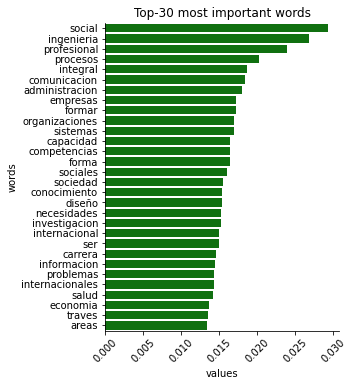

In [32]:
plt.figure(figsize=(15,10))
g = sns.catplot(data=word_val_data, color='green',
                 x='values', y='words', kind='bar' )
g.ax.tick_params(axis='x', rotation=45)
g.ax.set_title( f"Top-{N_WORDS} most important words" )
plt.show()

# KMeans

## Selecting number of clusters
* Silhouette Score

In [33]:
from sklearn.metrics import silhouette_score, silhouette_samples


In [38]:
%%time
cluster_sizes = range(2, 11+1)
kmeans_models = [ KMeans(i, n_init=10, random_state=2140) for i in cluster_sizes ]
cluster_score = []

for kmeans in kmeans_models:
    y = kmeans.fit_predict(X)
    score = silhouette_score(X, y)
    cluster_score.append( ( kmeans.n_clusters, score) )

cluster_score=np.array(cluster_score)

CPU times: user 14.5 s, sys: 158 ms, total: 14.6 s
Wall time: 3.85 s


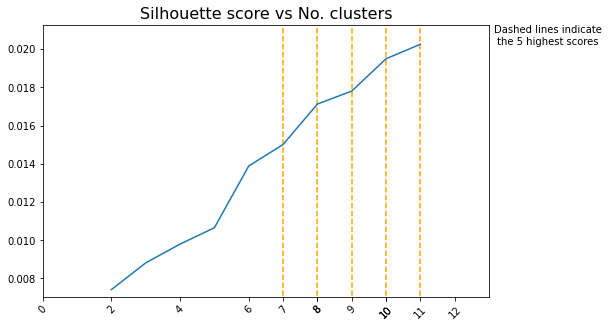

CPU times: user 1.15 s, sys: 79.5 ms, total: 1.23 s
Wall time: 308 ms


In [39]:
%%time
scores = cluster_score[:, 1]
clusters = cluster_score[:, 0]
max_score_clusters = []

fig, ax = plt.subplots( figsize=(8,5) )
ax = sns.lineplot( x=clusters, y=scores, ax=ax )
ax.set_title("Silhouette score vs No. clusters", fontsize=16)

for i in np.argsort( scores )[-5:]:
    ax.vlines(clusters[i], 0, 1, linestyles='--', colors='orange')
    max_score_clusters.append( clusters[i] )

ax.text(1.01, 1, f"Dashed lines indicate\n the {len(max_score_clusters)} highest scores",
        transform=ax.transAxes, ha='left', va='top')

xticks = ax.get_xticks().astype(int)
xticks = np.append(xticks, max_score_clusters)
ax.set_xticks( xticks )
ax.tick_params(axis='x', rotation=45)

ax.set_ylim( [ 0.95*min(scores), 1.05*max(scores) ] )
ax.set_xlim( [ 0, max(clusters)+2 ] )

plt.show()

## Depending on the Silhouette Score above will chose K=10

In [40]:
n_clusters=10
kmeans_model = KMeans(n_clusters, n_init=20, random_state=2140)
y = kmeans_model.fit_predict(X)

## Results visualization of Silhouette Score

### Silhouette samples

In [41]:
sample_scores = silhouette_samples( X, y )
sample_scores_df =  pd.DataFrame( data = {'Cluster':y, 'Silhouette':sample_scores} )
sample_scores_df = sample_scores_df.reset_index()
sample_scores_df=sample_scores_df.sort_values('Silhouette', ascending=False)
sample_scores_df

,index,Cluster,Silhouette
829,829,9,0.438385
915,915,9,0.438385
119,119,9,0.438385
896,896,9,0.438385
264,264,9,0.438385
...,...,...,...
938,938,8,-0.052585
187,187,0,-0.055811
261,261,8,-0.056176
541,541,4,-0.063684


In [96]:
sample_scores_df.Cluster.unique()

array([9, 3, 1, 6, 7, 5, 0, 8, 2, 4], dtype=int32)

In [45]:
def plot_silhouette_samples(X, pred_labels):
    n_clusters = len(np.unique(pred_labels))

    fig, (ax) = plt.subplots(1, 1, figsize=(8,8))
  
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

    silhouette_avg = silhouette_score(X, pred_labels)
    sample_silhouette_values = silhouette_samples(X, pred_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[pred_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
  
        ax.fill_betweenx(np.arange(y_lower, y_upper), 
                     0, ith_cluster_silhouette_values )
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),
            ha='center', va='center', fontsize=12,
            bbox={'boxstyle':'square',
                  'facecolor':'white'})
        y_lower = y_upper + 10
  
    ax.set_title(f"The silhouette score plot for the {n_clusters} clusters.\n",fontsize=20)
    ax.set_xlabel("Silhouette coefficient values",fontsize=18)
    ax.set_ylabel("Cluster",fontsize=18)
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    fig.savefig("silhouette.png")
    plt.show()

    return ax

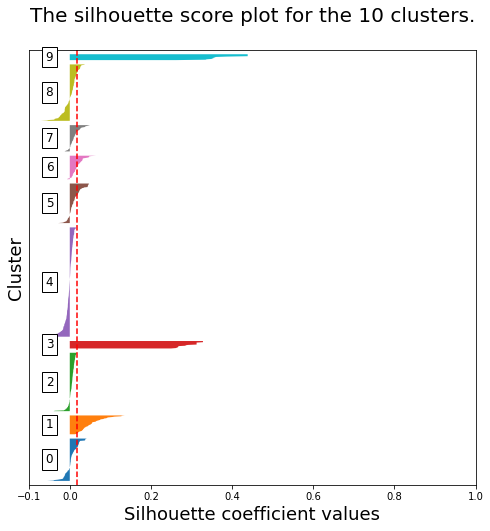

<AxesSubplot:title={'center':'The silhouette score plot for the 10 clusters.\n'}, xlabel='Silhouette coefficient values', ylabel='Cluster'>

In [46]:
plot_silhouette_samples(X, y)

## Most Important top 5 Words in each cluster

In [47]:
def most_important_words(data_tfidf, y, topn=20):
    n_clusters = len(np.unique(y))
    result = []
    for i in range(n_clusters):
        ith_cluter_word_sum = np.mean(data_tfidf[np.argwhere(y==i).flatten()], axis=0)
    
        word_ids = np.array( np.argsort( ith_cluter_word_sum )[0, -topn:] )
        word_ids = word_ids.reshape( -1 )
        result = result + [ (i, id, ith_cluter_word_sum[0, id] ) for id in word_ids ]

    return result

In [92]:
word_cluster_df = pd.DataFrame( most_important_words( X, y, topn=20 ), columns=["Cluster", "WordId", "Score"] )
word_cluster_df["Word"] = word_cluster_df["WordId"].apply( lambda id: vectorizer.get_feature_names()[id] )
word_cluster_df = word_cluster_df.sort_values( "Score", ascending=False )
word_cluster_df.head()

,Cluster,WordId,Score,Word
39,1,222,0.302138,comunicacion
79,3,1115,0.250837,solidaria
199,9,522,0.223151,financiera
78,3,392,0.204487,economia
198,9,38,0.196958,administracion


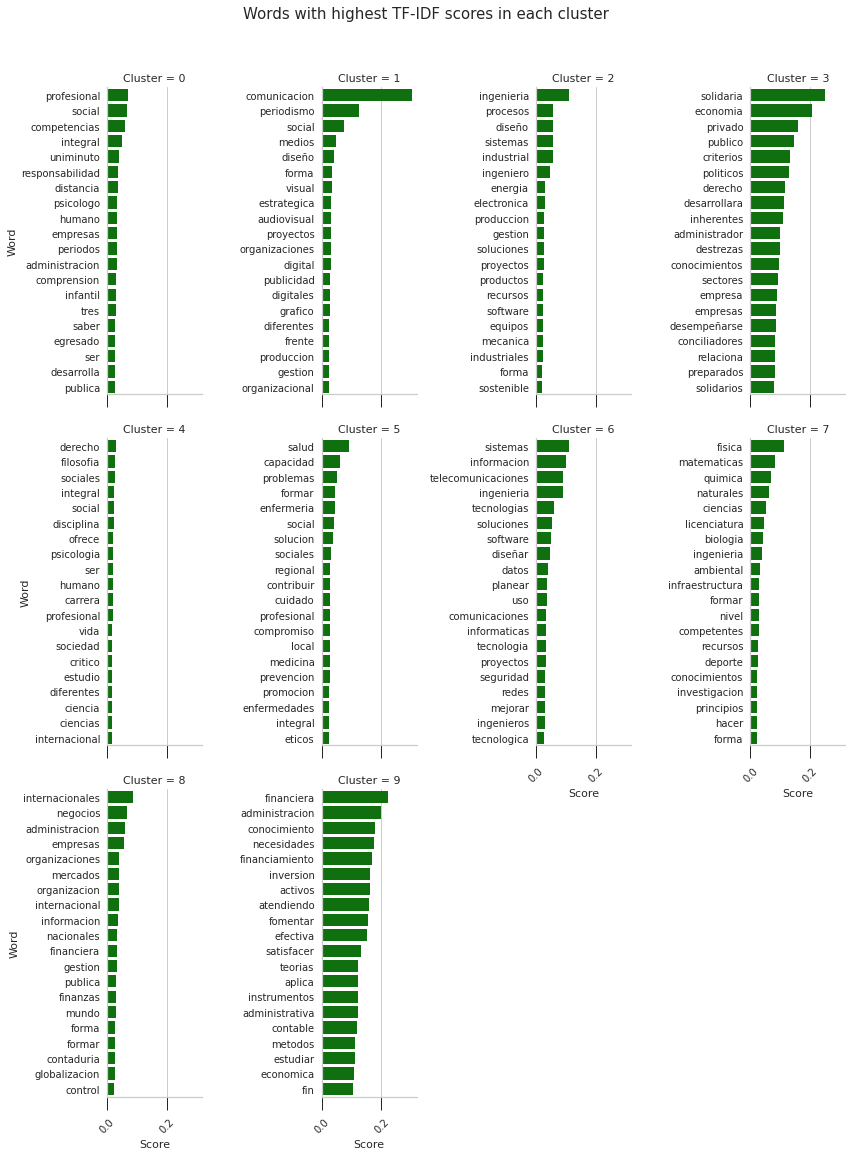

In [93]:
g = sns.catplot(x="Score", y="Word", col="Cluster", data=word_cluster_df, 
                sharey=False, col_wrap=4, kind="bar",
                color = 'green', aspect=.6)
[ ax.tick_params(axis='x', rotation=45, size=13) for ax in g.axes.flatten() ]
g.fig.suptitle( "Words with highest TF-IDF scores in each cluster", y = 1.05, fontsize=15 )
g.fig.savefig("kmeans_clusters_top20WordsperEach.png".format(i))
plt.show()

In [59]:
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())
final_df = tf_idf
print("{} rows".format(final_df.shape[0]))
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

1000 rows


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
preparados,0.269361,0.0,0.0,0.0,0.0,0.0,0.269361,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
relaciona,0.269361,0.0,0.0,0.0,0.0,0.0,0.269361,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
particularidades,0.264782,0.0,0.0,0.0,0.0,0.0,0.264782,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
mundiales,0.260601,0.0,0.0,0.0,0.0,0.0,0.260601,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333897,0.0,0.0
practicos,0.246779,0.0,0.0,0.0,0.0,0.0,0.246779,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## Most Important top 20 Words in each cluster

In [61]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    fig = plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        fig.savefig("kmeans_cluster{}_topWordsFIG.png".format(i))
        plt.show()
    


In [97]:
%%time
final_df_array = final_df.to_numpy()
prediction = kmeans_model.predict(final_df)


CPU times: user 134 ms, sys: 39.6 ms, total: 174 ms
Wall time: 58.9 ms


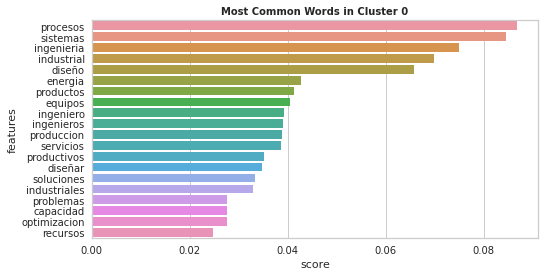

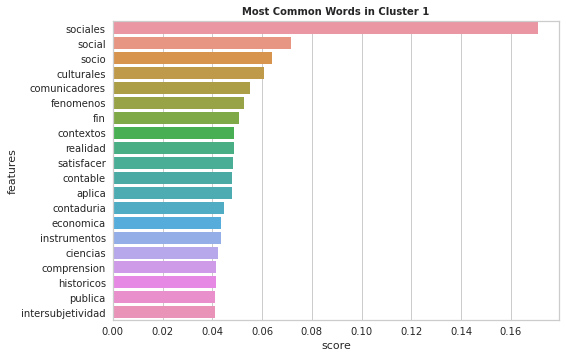

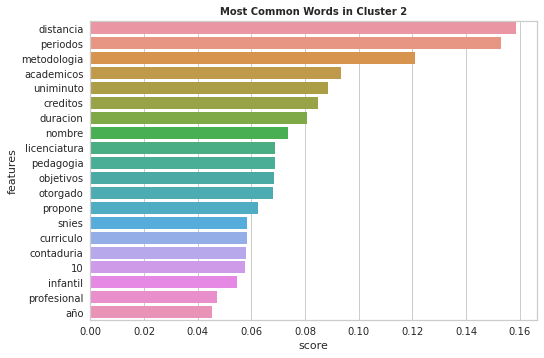

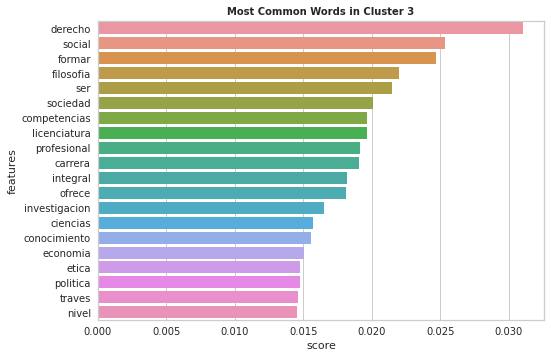

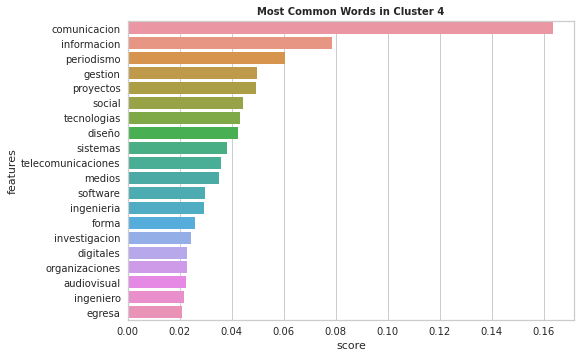

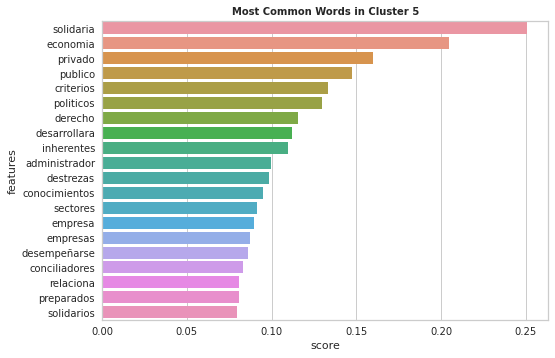

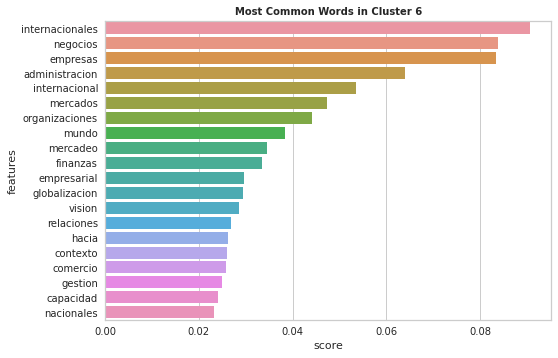

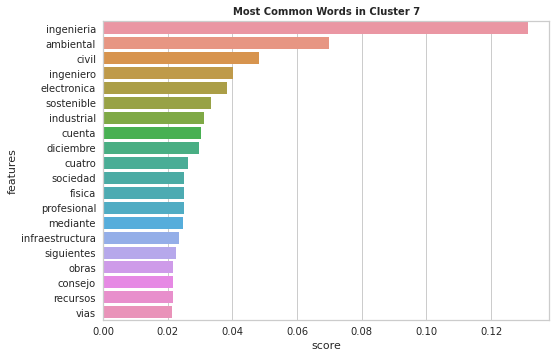

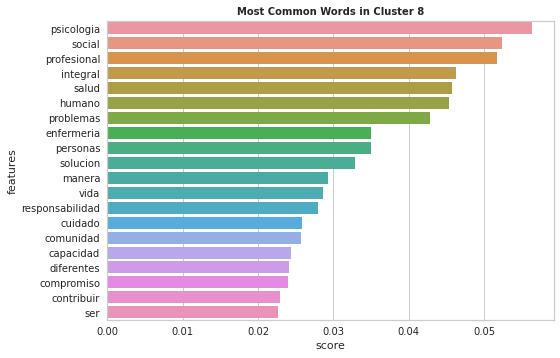

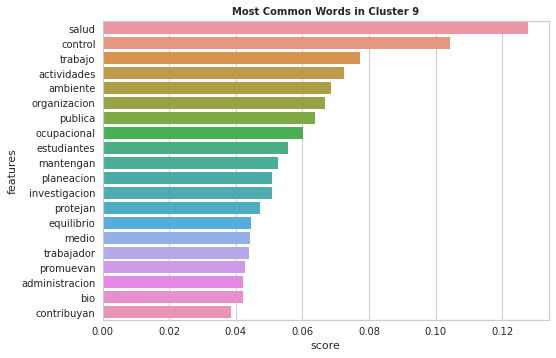

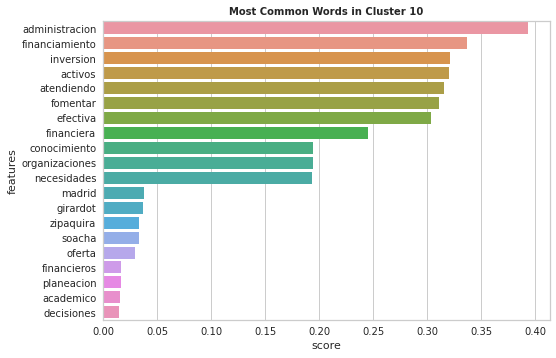

In [98]:
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, n_feats)

## Word Cloud for Each Cluster

### Transforms a centroids dataframe into a dictionary to be used on a WordCloud.

In [99]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        fig = plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        fig.savefig("WordClouds_clusters{}_topWors.png".format(i))
        plt.show()

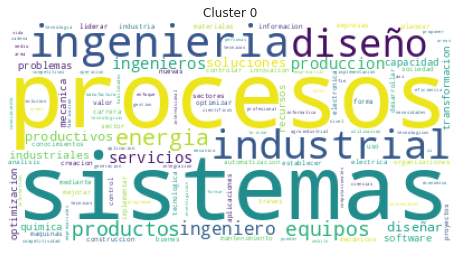

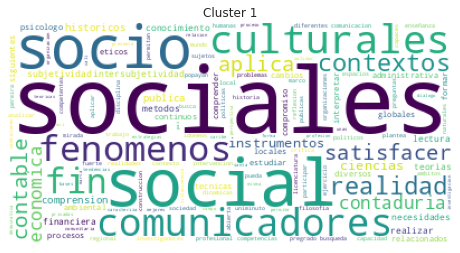

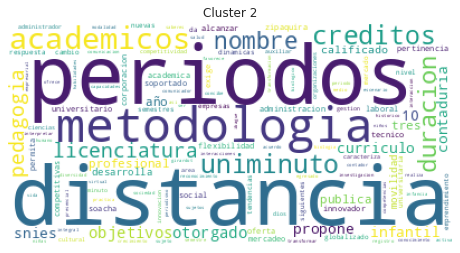

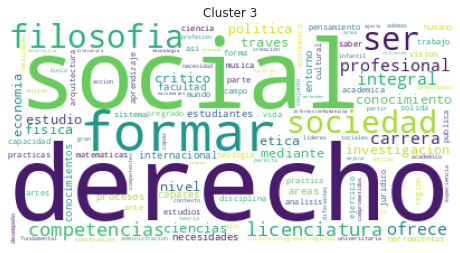

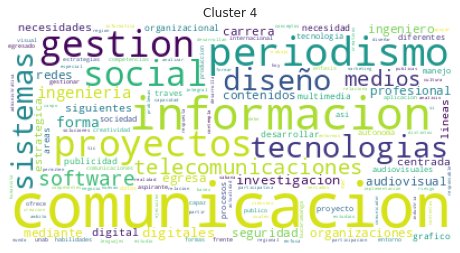

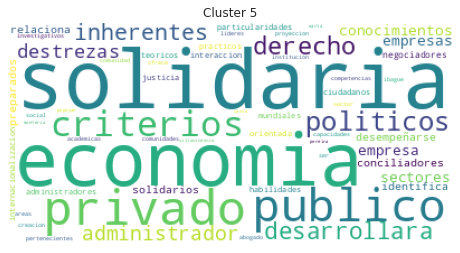

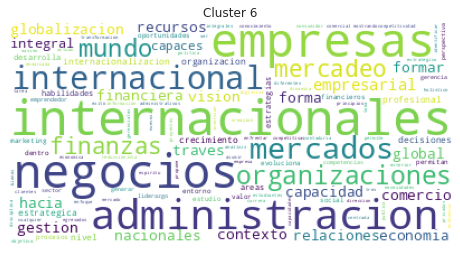

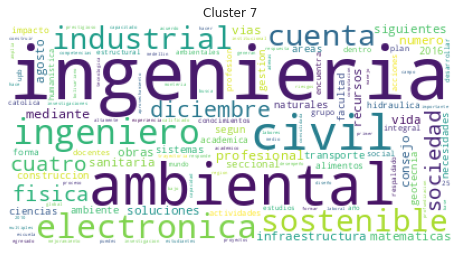

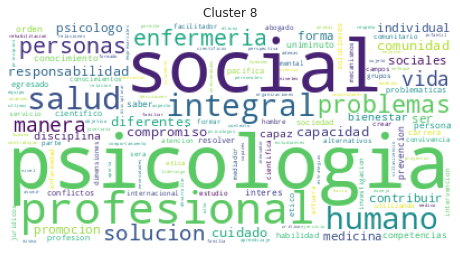

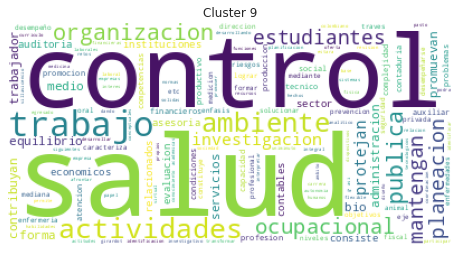

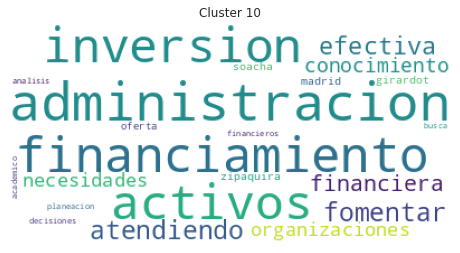

In [102]:
centroids = pd.DataFrame(kmeans_model.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [146]:
final_df.to_csv("final_df.csv")
centroids.to_csv("centroids.csv")
df_clustered.to_csv("clustered_data_withCentroids.csv")

In [103]:
df_clustered = df1.copy()

In [104]:
# Assigning the cluster labels to each country
labels = kmeans_model.labels_ 
df_clustered['Cluster'] = labels
df_clustered.head()

,undergraduate,university,details,description,SNIES,Qualified record,Level of Education,Type of training,Title awarded,Modality,Duration,Credits,Town,final_cat,token,token_no_stopwords,bigram,Cluster
1,contaduria publica,universidad cooperativa de colombia - sede apa...,objeto de estudio,las particularidades de este programa que se r...,104897,"resolucion 14090 del 07 de septiembre de 2015,...",pregrado,universitaria,contador publico,presencial,8 semestres,144,apartado,BUSINESS,"[las, particularidades, de, este, programa, qu...","[particularidades, relaciona, economia, solida...","[(particularidades, relaciona), (relaciona, ec...",5
2,derecho,universidad cooperativa de colombia - sede apa...,,"el programa de derecho, estudia el sistema jur...",102434,"resolucion 9967 del 17 de junio de 2020, vigen...",pregrado,universitaria,abogado,presencial,10 semestres,158,apartado,HUMANITIES AND SOCIAL SCIENCE,"[el, programa, de, derecho, ,, estudia, el, si...","[derecho, estudia, sistema, juridico, sera, ob...","[(derecho, estudia), (estudia, sistema), (sist...",3
3,psicologia,universidad cooperativa de colombia - sede arauca,,"en la universidad cooperativa de colombia, el ...",54920,"resolucion 16951 del 22 de agosto de 2016​, vi...",pregrado,profesional universitaria,psicologo,presencial,8 semestres,147,arauca,HUMANITIES AND SOCIAL SCIENCE,"[en, la, universidad, cooperativa, de, colombi...","[psicologia, ademas, investigacion, dimension,...","[(psicologia, ademas), (ademas, investigacion)...",8
4,derecho,universidad cooperativa de colombia - sede arauca,abordar el sistema juridico como conjunto de n...,el programa de derecho que se ofrece en la ins...,8630,"resolucion 10893 del 01 de junio de 2016, vige...",pregrado,universitaria,abogado,presencial,10 semestres,158,arauca,HUMANITIES AND SOCIAL SCIENCE,"[el, programa, de, derecho, que, se, ofrece, e...","[derecho, ofrece, institucion, identifica, ciu...","[(derecho, ofrece), (ofrece, institucion), (in...",5
5,administracion de empresas,universidad cooperativa de colombia - sede arauca,campos de accionel administrador de empresas d...,la organizacion entendida como un conjunto de...,8690,"resolucion 08682 del 02 de mayo de 2016, vigen...",pregrado,profesional universitaria,administrador de empresas,presencial,8 semestres,143,arauca,BUSINESS,"[la, organizacion, entendida, como, un, conju...","[la, organizacion, entendida, conjunto, recur...","[(la, organizacion), (organizacion, entendida...",3


In [86]:
df_clustered['Silhouette_score'] = scores_df['Silhouette']
df_clustered.head()

,undergraduate,university,details,description,SNIES,Qualified record,Level of Education,Type of training,Title awarded,Modality,Duration,Credits,Town,final_cat,token,token_no_stopwords,bigram,Cluster,Silhouette_score
1,contaduria publica,universidad cooperativa de colombia - sede apa...,objeto de estudio,las particularidades de este programa que se r...,104897,"resolucion 14090 del 07 de septiembre de 2015,...",pregrado,universitaria,contador publico,presencial,8 semestres,144,apartado,BUSINESS,"[las, particularidades, de, este, programa, qu...","[particularidades, relaciona, economia, solida...","[(particularidades, relaciona), (relaciona, ec...",5,-0.005522
2,derecho,universidad cooperativa de colombia - sede apa...,,"el programa de derecho, estudia el sistema jur...",102434,"resolucion 9967 del 17 de junio de 2020, vigen...",pregrado,universitaria,abogado,presencial,10 semestres,158,apartado,HUMANITIES AND SOCIAL SCIENCE,"[el, programa, de, derecho, ,, estudia, el, si...","[derecho, estudia, sistema, juridico, sera, ob...","[(derecho, estudia), (estudia, sistema), (sist...",5,-0.016341
3,psicologia,universidad cooperativa de colombia - sede arauca,,"en la universidad cooperativa de colombia, el ...",54920,"resolucion 16951 del 22 de agosto de 2016​, vi...",pregrado,profesional universitaria,psicologo,presencial,8 semestres,147,arauca,HUMANITIES AND SOCIAL SCIENCE,"[en, la, universidad, cooperativa, de, colombi...","[psicologia, ademas, investigacion, dimension,...","[(psicologia, ademas), (ademas, investigacion)...",3,0.328151
4,derecho,universidad cooperativa de colombia - sede arauca,abordar el sistema juridico como conjunto de n...,el programa de derecho que se ofrece en la ins...,8630,"resolucion 10893 del 01 de junio de 2016, vige...",pregrado,universitaria,abogado,presencial,10 semestres,158,arauca,HUMANITIES AND SOCIAL SCIENCE,"[el, programa, de, derecho, que, se, ofrece, e...","[derecho, ofrece, institucion, identifica, ciu...","[(derecho, ofrece), (ofrece, institucion), (in...",8,0.005707
5,administracion de empresas,universidad cooperativa de colombia - sede arauca,campos de accionel administrador de empresas d...,la organizacion entendida como un conjunto de...,8690,"resolucion 08682 del 02 de mayo de 2016, vigen...",pregrado,profesional universitaria,administrador de empresas,presencial,8 semestres,143,arauca,BUSINESS,"[la, organizacion, entendida, como, un, conju...","[la, organizacion, entendida, conjunto, recur...","[(la, organizacion), (organizacion, entendida...",2,-0.002294


In [123]:
from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Category10
import umap
from sklearn.decomposition import PCA

In [124]:
#2D view of clusters and data with U-Map
output_notebook()

Loading BokehJS ...

In [126]:
pca = PCA( 0.95, random_state=2140)
data_pca = pca.fit_transform(X.todense())

In [127]:
umap_red = umap.UMAP(n_neighbors=12, metric='correlation', 
                     random_state=214)
data_2d = umap_red.fit_transform( data_pca )

In [128]:
data_2d

array([[ 7.223454 ,  7.4368567],
       [ 1.5734522,  8.480722 ],
       [ 1.2174858,  6.7593   ],
       ...,
       [-0.5773373,  8.629512 ],
       [-1.9028841,  8.272332 ],
       [ 0.6272265,  6.233774 ]], dtype=float32)

In [109]:
from sklearn.model_selection import train_test_split


In [110]:
df1.description = df1['description'].astype(str) 

<1000x1219 sparse matrix of type '<class 'numpy.float64'>'
	with 20568 stored elements in Compressed Sparse Row format>

In [129]:
data_2d_df.head()

,x,y,Cluster,Silhouette,colors,description
302,5.866436,2.900148,2,0.006018,#2ca02c,NaN
271,8.552696,1.992553,4,-0.003993,#9467bd,NaN
572,9.287486,-1.271317,4,-0.004821,#9467bd,"forma un profesional lider, innovador, abierto..."
480,10.008573,3.170199,4,0.003903,#9467bd,NaN
426,7.414694,-0.047475,2,-0.003189,#2ca02c,NaN


In [134]:
data_2d_df = pd.DataFrame( data={"x":data_2d[:, 0], 
                                 "y":data_2d[:, 1], 
                                 "Cluster":y,
                                 "Silhouette":sample_scores } )

c_pallete = list(Category10[10])
c_pallete[7], c_pallete[0] = c_pallete[0], c_pallete[7]

data_2d_df['colors'] = [ c_pallete[i] for i in data_2d_df['Cluster'] ]
data_2d_df['description'] = df1['description']

In [137]:
data_2d_df = data_2d_df.fillna(' ')

In [139]:
#Limiting the text's size
data_2d_df['description'] = data_2d_df['description'].str.slice(0,5)

data_2d_df, _,_,_ = train_test_split(data_2d_df, data_2d_df, train_size=800, stratify=data_2d_df['Cluster'])

data_2d_cdf = ColumnDataSource(data_2d_df)

In [140]:
fig = figure(
    title='UMAP 2D projection of the points and clusters',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset', 'save')
)

fig.add_tools(HoverTool(tooltips="""
                                      <div>
                                        <span style='font-size: 10px; color: @colors'>@ementa</span>
                                        <span style='font-size: 10px'>cluster - </span>
                                        <span style='font-size: 10px'>@Cluster ;</span>
                                        <span style='font-size: 10px'>index - </span>
                                        <span style='font-size: 10px'>$index ;</span>
                                        <span style='font-size: 10px'>silhouette: </span>
                                        <span style='font-size: 10px'>@Silhouette</span>
                                      </div>
                                 """)
              )

fig.circle('x','y', source=data_2d_cdf, color='colors', 
           legend_group="Cluster",
           line_alpha=0.6, fill_alpha=0.6, size=2)

show(fig)
save(fig, "UMAP2D.html")

'/kaggle/working/UMAP2D.html'

# Geo Vizualisation

In [141]:
# Map Viz
import json
import geopandas as gpd

## Loading countries polygons
geo_path = '../input/colombia-topogeojson/Colombia_departamentos_municipios_poblacion-topo.json'
#colombia_geo = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)
gpf.head(2)

,id,OBJECTID,DPTO_CCDGO,DPTO_CNMBR,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP34_9_ED,STP51_PRIM,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Length,Shape_Area,geometry
0,None,1,18,CAQUETÁ,2019,9.010301e+10,0.798556,-73.959468,163381,1117,...,4885,113225,24649,17680,904,17844,10238,21.384287,7.318485,"MULTIPOLYGON (((-74.59963 2.63597, -74.68088 2..."
1,None,2,19,CAUCA,2019,3.124291e+10,2.396834,-76.824233,622959,83033,...,25952,434283,195877,105690,7288,56673,17057,13.950263,2.534419,"MULTIPOLYGON (((-76.35121 3.28625, -76.34346 3..."
